Files loaded successfully.


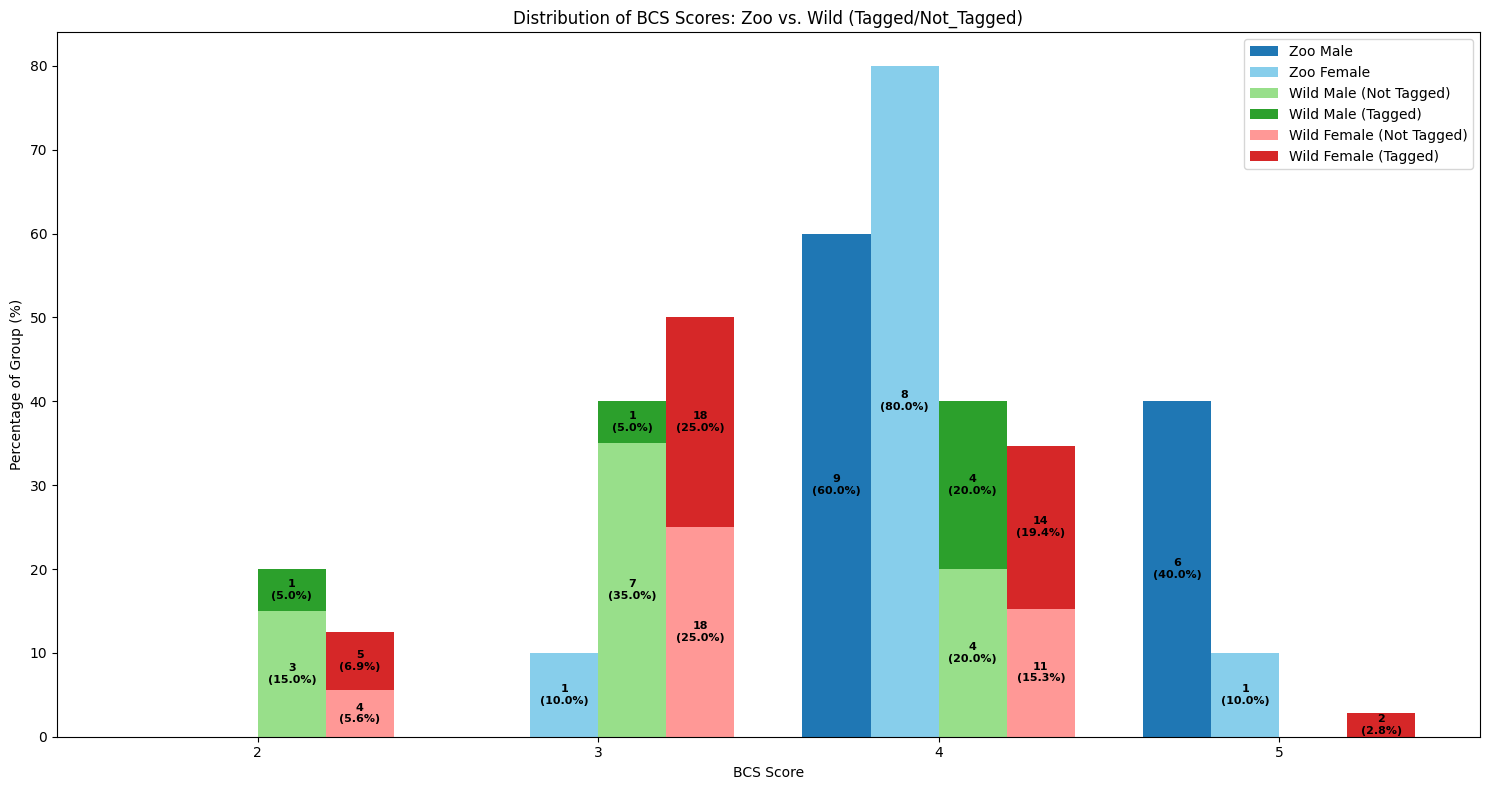

Data sample (first 5 rows):


,Date,Sex,Age_group,BCS,Source,Tag_Status
0,01/11/2020,Male,בוגר,4,Zoo,Not_Tagged
1,01/11/2020,Male,בוגר,4,Zoo,Not_Tagged
2,01/11/2020,Male,בוגר,4,Zoo,Not_Tagged
3,01/11/2020,Male,בוגר,4,Zoo,Not_Tagged
4,01/11/2020,Male,בוגר,5,Zoo,Not_Tagged


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ביטול הגדרות שמכבידות על התצוגה
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# ---------------------------------------------------------
# שלב 1: טעינת הנתונים
# ---------------------------------------------------------
try:
    zoo_df = pd.read_csv('zoo_data2.csv')
    wild_df = pd.read_csv('wildlife_data.csv')
    print("Files loaded successfully.")
except FileNotFoundError:
    print("Error: Files not found. Please upload correct CSV files.")

# ---------------------------------------------------------
# שלב 2: פונקציית ניקוי וסידור
# ---------------------------------------------------------
def clean_dataframe(df, source_name):
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    df.columns = df.columns.str.strip()

    for col in df.columns:
        if col.lower() in ['sex', 'מין', 'gender']:
            df.rename(columns={col: 'Sex'}, inplace=True)
        if col.lower() in ['bcs', 'ציון', 'score']:
            df.rename(columns={col: 'BCS'}, inplace=True)

    if 'Sex' in df.columns:
        df['Sex'] = df['Sex'].astype(str).str.strip()
        sex_map = {
            'זכר': 'Male', 'נקבה': 'Female',
            'Male': 'Male', 'Female': 'Female',
            'male': 'Male', 'female': 'Female'
        }
        df['Sex'] = df['Sex'].map(sex_map)

    df['Source'] = source_name
    return df

zoo_df = clean_dataframe(zoo_df, 'Zoo')
wild_df = clean_dataframe(wild_df, 'Wild')

# ---------------------------------------------------------
# שלב 3: טיפול בסימון (Tagging)
# ---------------------------------------------------------
zoo_df['Tag_Status'] = 'Not_Tagged'

tag_col = None
for col in wild_df.columns:
    if any(x in col.lower() for x in ['tag', 'סימון', 'marking']):
        tag_col = col
        break

if tag_col:
    def determine_tag(val):
        s = str(val).strip()
        if s == 'nan' or s == '': return 'Not_Tagged'
        if 'לא' in s or 'Not' in s or 'not' in s: return 'Not_Tagged'
        if 'מסומן' in s or 'Tagged' in s or 'Yes' in s or 'כן' in s: return 'Tagged'
        return 'Not_Tagged'

    wild_df['Tag_Status'] = wild_df[tag_col].apply(determine_tag)
    if tag_col != 'Tag_Status':
        wild_df = wild_df.drop(columns=[tag_col])
else:
    wild_df['Tag_Status'] = 'Not_Tagged'

cols_to_drop = [c for c in zoo_df.columns if 'tag' in c.lower() and c != 'Tag_Status']
if cols_to_drop:
    zoo_df = zoo_df.drop(columns=cols_to_drop)

# איחוד נתונים
full_data = pd.concat([zoo_df, wild_df], ignore_index=True)
full_data = full_data.dropna(subset=['Sex', 'BCS'])
full_data = full_data[full_data['Sex'].isin(['Male', 'Female'])]
full_data['BCS'] = pd.to_numeric(full_data['BCS'], errors='coerce')
full_data = full_data.dropna(subset=['BCS'])

# ---------------------------------------------------------
# שלב 4: בניית והצגת הגרף
# ---------------------------------------------------------
bcs_scores = sorted(full_data['BCS'].unique())
plot_data = []

for bcs in bcs_scores:
    # Zoo Calc
    zoo_m_all = full_data[(full_data['Source'] == 'Zoo') & (full_data['Sex'] == 'Male')]
    zoo_m_curr = zoo_m_all[zoo_m_all['BCS'] == bcs]
    pct_zoo_m = (len(zoo_m_curr) / len(zoo_m_all) * 100) if len(zoo_m_all) > 0 else 0

    zoo_f_all = full_data[(full_data['Source'] == 'Zoo') & (full_data['Sex'] == 'Female')]
    zoo_f_curr = zoo_f_all[zoo_f_all['BCS'] == bcs]
    pct_zoo_f = (len(zoo_f_curr) / len(zoo_f_all) * 100) if len(zoo_f_all) > 0 else 0

    # Wild Calc
    wild_m_all = full_data[(full_data['Source'] == 'Wild') & (full_data['Sex'] == 'Male')]
    wild_m_tagged = wild_m_all[(wild_m_all['BCS'] == bcs) & (wild_m_all['Tag_Status'] == 'Tagged')]
    wild_m_untagged = wild_m_all[(wild_m_all['BCS'] == bcs) & (wild_m_all['Tag_Status'] == 'Not_Tagged')]
    pct_wild_m_tagged = (len(wild_m_tagged) / len(wild_m_all) * 100) if len(wild_m_all) > 0 else 0
    pct_wild_m_untagged = (len(wild_m_untagged) / len(wild_m_all) * 100) if len(wild_m_all) > 0 else 0

    wild_f_all = full_data[(full_data['Source'] == 'Wild') & (full_data['Sex'] == 'Female')]
    wild_f_tagged = wild_f_all[(wild_f_all['BCS'] == bcs) & (wild_f_all['Tag_Status'] == 'Tagged')]
    wild_f_untagged = wild_f_all[(wild_f_all['BCS'] == bcs) & (wild_f_all['Tag_Status'] == 'Not_Tagged')]
    pct_wild_f_tagged = (len(wild_f_tagged) / len(wild_f_all) * 100) if len(wild_f_all) > 0 else 0
    pct_wild_f_untagged = (len(wild_f_untagged) / len(wild_f_all) * 100) if len(wild_f_all) > 0 else 0

    plot_data.append({
        'BCS': bcs,
        'Zoo_M_Pct': pct_zoo_m, 'Zoo_M_Count': len(zoo_m_curr),
        'Zoo_F_Pct': pct_zoo_f, 'Zoo_F_Count': len(zoo_f_curr),
        'Wild_M_Tag_Pct': pct_wild_m_tagged, 'Wild_M_Tag_Count': len(wild_m_tagged),
        'Wild_M_Untag_Pct': pct_wild_m_untagged, 'Wild_M_Untag_Count': len(wild_m_untagged),
        'Wild_F_Tag_Pct': pct_wild_f_tagged, 'Wild_F_Tag_Count': len(wild_f_tagged),
        'Wild_F_Untag_Pct': pct_wild_f_untagged, 'Wild_F_Untag_Count': len(wild_f_untagged)
    })

df_plot = pd.DataFrame(plot_data)

# צבעים
c_zoo_m = '#1f77b4'  # כחול (זכר גן חיות)
c_zoo_f = '#87CEEB'  # תכלת (נקבה גן חיות)
c_wild_m_tagged = '#2ca02c'
c_wild_m_untagged = '#98df8a'
c_wild_f_tagged = '#d62728'
c_wild_f_untagged = '#ff9896'

fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.2
x = np.arange(len(bcs_scores))

rects1 = ax.bar(x - 1.5*bar_width, df_plot['Zoo_M_Pct'], bar_width, label='Zoo Male', color=c_zoo_m)
rects2 = ax.bar(x - 0.5*bar_width, df_plot['Zoo_F_Pct'], bar_width, label='Zoo Female', color=c_zoo_f)
rects3_btm = ax.bar(x + 0.5*bar_width, df_plot['Wild_M_Untag_Pct'], bar_width, label='Wild Male (Not Tagged)', color=c_wild_m_untagged)
rects3_top = ax.bar(x + 0.5*bar_width, df_plot['Wild_M_Tag_Pct'], bar_width, bottom=df_plot['Wild_M_Untag_Pct'], label='Wild Male (Tagged)', color=c_wild_m_tagged)
rects4_btm = ax.bar(x + 1.5*bar_width, df_plot['Wild_F_Untag_Pct'], bar_width, label='Wild Female (Not Tagged)', color=c_wild_f_untagged)
rects4_top = ax.bar(x + 1.5*bar_width, df_plot['Wild_F_Tag_Pct'], bar_width, bottom=df_plot['Wild_F_Untag_Pct'], label='Wild Female (Tagged)', color=c_wild_f_tagged)

def add_labels(rects, counts, pcts):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if height > 0.1:
            count = int(counts[i])
            pct = pcts[i]
            y_pos = rect.get_y() + height / 2
            ax.text(rect.get_x() + rect.get_width()/2., y_pos,
                    f'{count}\n({pct:.1f}%)',
                    ha='center', va='center', fontsize=8, color='black', fontweight='bold')

add_labels(rects1, df_plot['Zoo_M_Count'], df_plot['Zoo_M_Pct'])
add_labels(rects2, df_plot['Zoo_F_Count'], df_plot['Zoo_F_Pct'])
add_labels(rects3_btm, df_plot['Wild_M_Untag_Count'], df_plot['Wild_M_Untag_Pct'])
add_labels(rects3_top, df_plot['Wild_M_Tag_Count'], df_plot['Wild_M_Tag_Pct'])
add_labels(rects4_btm, df_plot['Wild_F_Untag_Count'], df_plot['Wild_F_Untag_Pct'])
add_labels(rects4_top, df_plot['Wild_F_Tag_Count'], df_plot['Wild_F_Tag_Pct'])

ax.set_ylabel('Percentage of Group (%)')
ax.set_xlabel('BCS Score')
ax.set_title('Distribution of BCS Scores: Zoo vs. Wild (Tagged/Not_Tagged)')
ax.set_xticks(x)
ax.set_xticklabels(bcs_scores)
ax.legend()

plt.tight_layout()
plt.show()

# רק בדיקה קטנה שהנתונים תקינים, בלי להעמיס
print("Data sample (first 5 rows):")
display(full_data.head())